### Load and plot some raw data

## Example notebook to look at cumulative dynamic strains


### Steps
- load metadata
- load 1 month of 1hz data (counts) to dataframe
- convert to microstrain
- highpass filter to remove non-seismic signals
- calculate dynamic strains
- select peaks based on width (ie 1 hr) and height (ie greater than x ustrain), calculate cumsum of peaks
- compare with earthquake catalog
- run same analysis using areal instead of dynamic strain 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from geopy.distance import distance
from scipy import signal
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.mseed_tools import load_mseed_to_df

In [2]:
%matplotlib widget
#%matplotlib inline

# input station params and load metadata
network = 'PB'
station = 'B944'
meta = GtsmMetadata(network,station)

In [3]:
%%time

#load data from miniseed
period = 1
start="2021-05-01T00:00:00"
end="2021-06-01T00:00:00"
df = load_mseed_to_df(net=network, sta=station, loc='T0', cha='LS*', start=start, end=end)
#remove 999999s
df = df.replace(999999,np.nan)
df

CPU times: user 5.47 s, sys: 539 ms, total: 6.01 s
Wall time: 17.4 s


,CH0,CH1,CH2,CH3
time,,,,
2021-05-01 00:00:00,48911123.0,51560740.0,51128839.0,52778593.0
2021-05-01 00:00:01,48911121.0,51560741.0,51128836.0,52778594.0
2021-05-01 00:00:02,48911122.0,51560741.0,51128837.0,52778595.0
2021-05-01 00:00:03,48911123.0,51560741.0,51128839.0,52778593.0
2021-05-01 00:00:04,48911124.0,51560742.0,51128838.0,52778590.0
...,...,...,...,...
2021-05-31 23:59:56,48906163.0,51562976.0,51129843.0,52776653.0
2021-05-31 23:59:57,48906164.0,51562975.0,51129845.0,52776648.0
2021-05-31 23:59:58,48906167.0,51562975.0,51129847.0,52776649.0


In [4]:
def plot(df,
         title: str = None,
         units: str = None,
         remove_9s: bool = True,
         zero: bool = False,
         detrend: str = None,
         ymin: float = None,
         ymax: float = None,
         plot_type: str = "scatter",
         save_as: str = None):
    
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(12,8), squeeze=False)
    if title:
        fig.suptitle(title)
    if remove_9s:
        df = df.replace(999999,np.nan)
    if zero:
        df -= df.loc[df.first_valid_index()]
    if detrend:
        if detrend == 'linear':
            for ch in df.columns:
                df[ch] = signal.detrend(df[ch], type='linear')
        else:
            print('Only linear detrend implemented')
    for i, ch in enumerate(df.columns):
        if plot_type == 'line':
            axs[i][0].plot(df[ch], color='black', label=ch)
        elif plot_type == 'scatter':
            axs[i][0].scatter(df.index, df[ch], color='black', s=2, label=ch)
        else:
            print("Plot type must be either 'line' or 'scatter'")
        if ymin or ymax:
            axs[i][0].set_ylim(ymin, ymax)
        if units:
            axs[i][0].set_ylabel(units)
        axs[i][0].ticklabel_format(axis='y', useOffset=False, style='plain')
        axs[i][0].legend(loc="upper right")
    fig.tight_layout()
    if save_as:
        logger.info(f"Saving plot to {save_as}")
        plt.savefig(save_as)



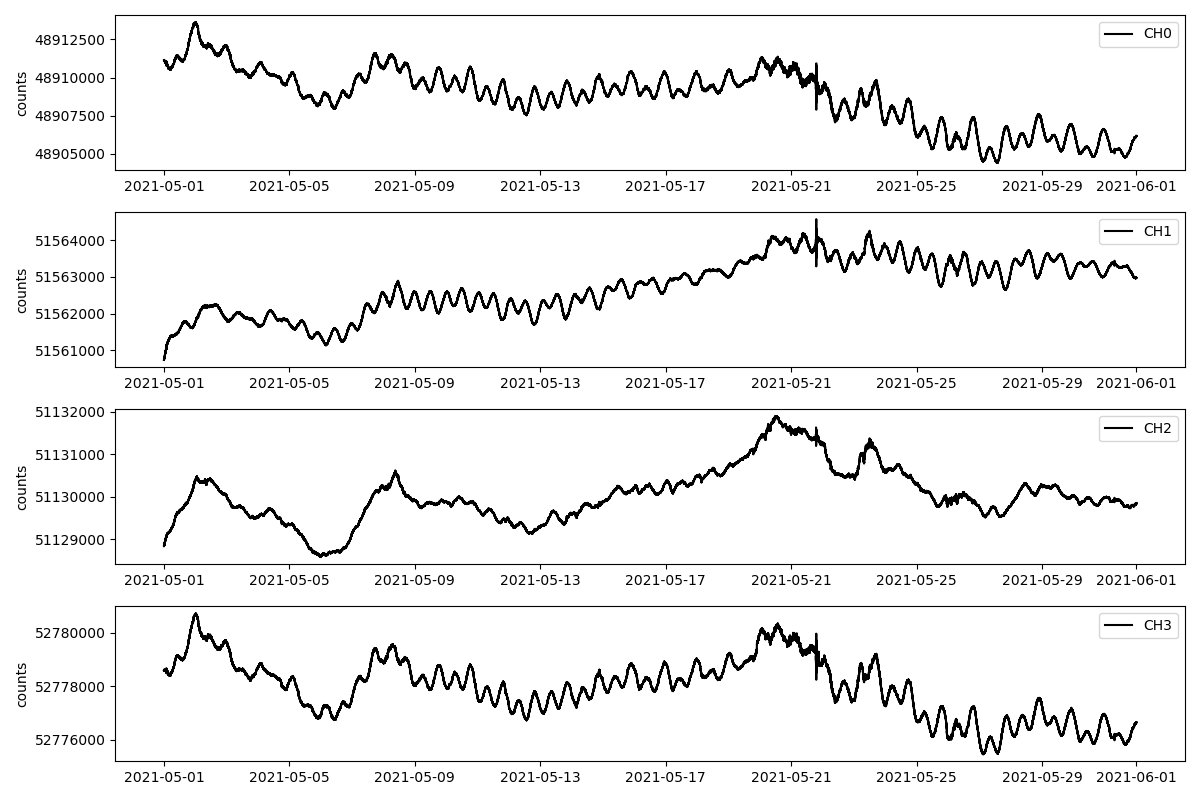

In [5]:
plot(df, 
     title = None,
     units = 'counts',
     remove_9s = False,
     zero = False,
     detrend = None,
     ymin = None,
     ymax = None,
     plot_type = "line",
     save_as = None)    

### Convert to microstrain

In [6]:
def linearize(df, gap):
    linearized_data = ((df / 100000000) / (1 - (df / 100000000)))  * \
                           (gap / 0.087) * 1000000
    return linearized_data

df_us = linearize(df, meta.gap)

### Highpass filter 1000s to remove non-seismic signals (Barbour et al 2021)

In [7]:
%%time

def butterworth_filter(df: pd.DataFrame,
                        period: float,
                        filter_type: str,
                        filter_order: int,
                        filter_cutoff_s: float):
    fc = 1 / filter_cutoff_s
    fs = 1 / period
    [bn, an] = signal.butter(filter_order, fc / (1 / 2 * fs), btype=filter_type)
    df2 = pd.DataFrame(index=df.index)
    for ch in df.columns:
        df2[ch] = signal.filtfilt(bn, an, df[ch])
    return df2


df_us=df_us.replace(999999,np.nan).interpolate()
df2 = butterworth_filter(df_us, period=period, filter_type='high', filter_order=2, filter_cutoff_s=1000)    
df2

CPU times: user 737 ms, sys: 531 ms, total: 1.27 s
Wall time: 1.27 s


,CH0,CH1,CH2,CH3
time,,,,
2021-05-01 00:00:00,-0.000059,-0.000061,-0.000004,0.000032
2021-05-01 00:00:01,-0.000149,-0.000013,-0.000150,0.000083
2021-05-01 00:00:02,-0.000106,-0.000015,-0.000102,0.000134
2021-05-01 00:00:03,-0.000064,-0.000016,-0.000007,0.000031
2021-05-01 00:00:04,-0.000021,0.000032,-0.000056,-0.000124
...,...,...,...,...
2021-05-31 23:59:56,-0.000592,0.000122,-0.000408,0.000216
2021-05-31 23:59:57,-0.000553,0.000075,-0.000313,-0.000043
2021-05-31 23:59:58,-0.000426,0.000077,-0.000219,0.000008


CPU times: user 1.23 s, sys: 1.82 s, total: 3.04 s
Wall time: 2.78 s


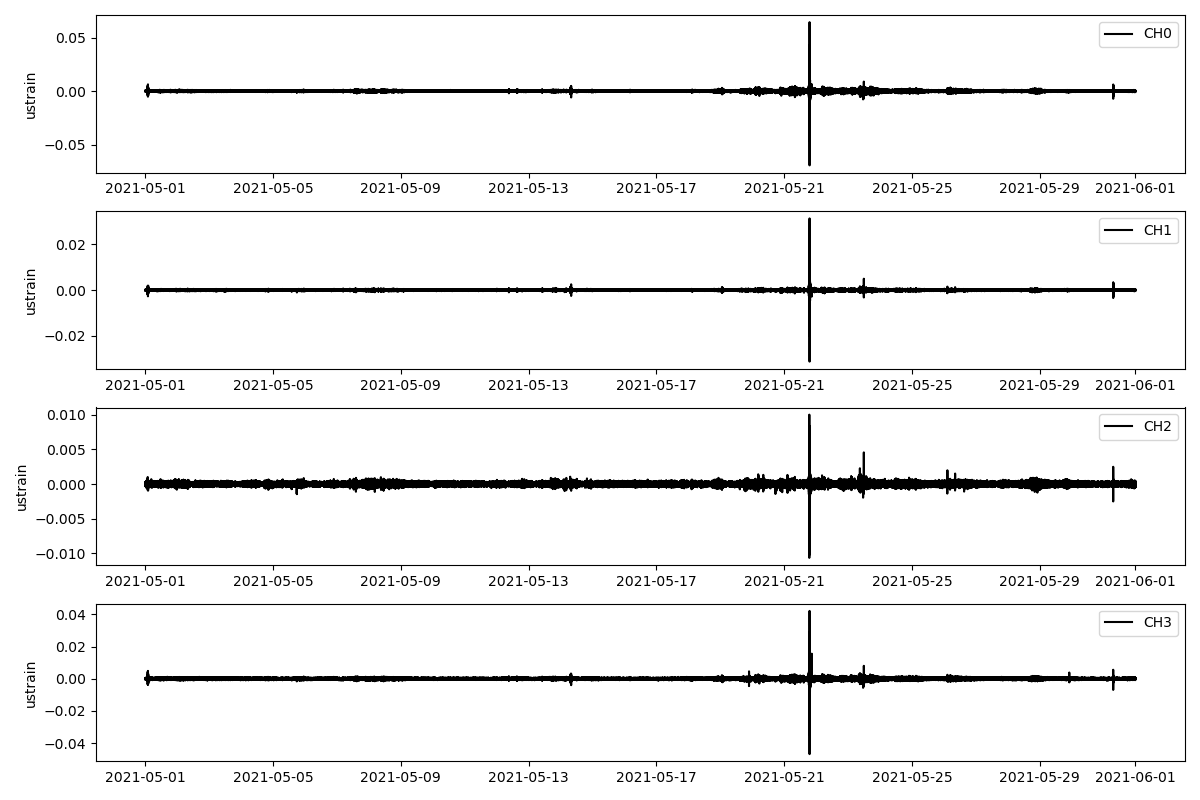

In [8]:
%%time

plot(df2, 
     title = None,
     units='ustrain',
     remove_9s = True,
     zero = False,
     detrend = None,
     ymin = None,
     ymax = None,
     plot_type = "line",
     save_as = None)  

# Dynamic strain
### Calculate dynamic strain using 4 gauges ala Barbour et al 2021

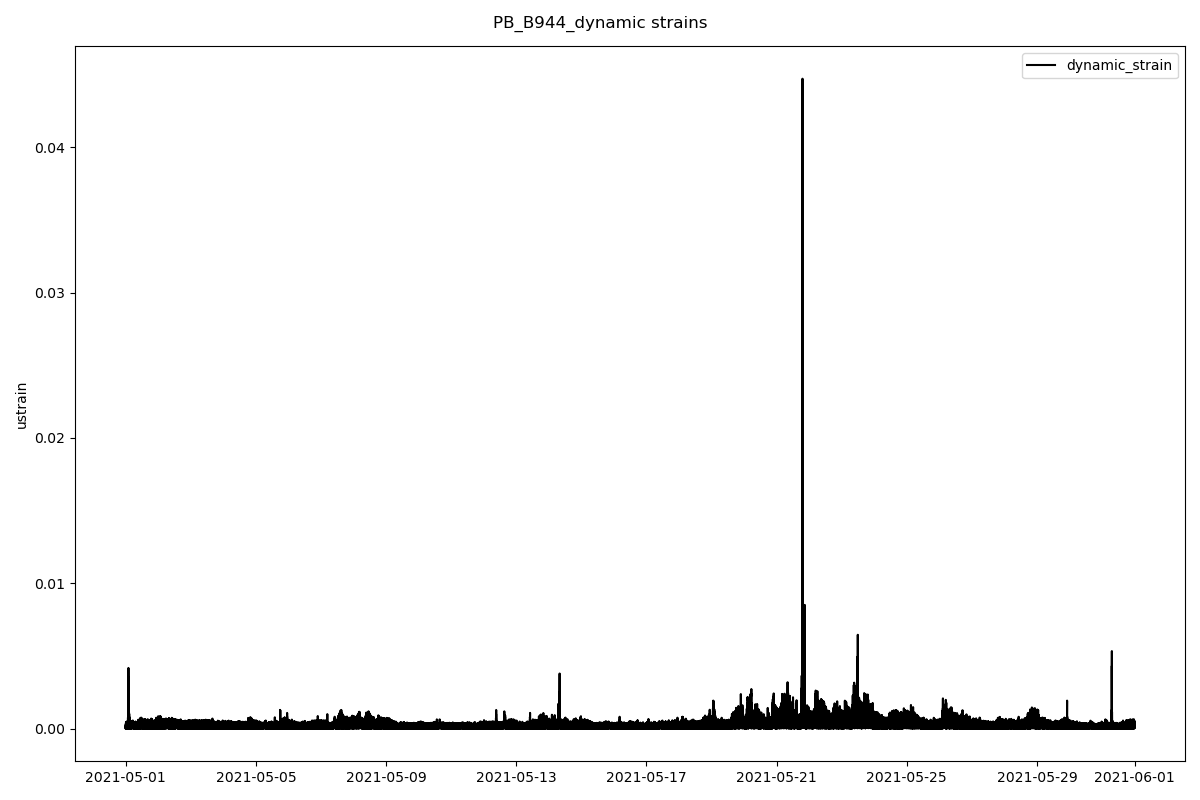

In [9]:
gauge_weights = [1,1,1,1]

def calc_peak_dynamic_strain(df):
    df_dynam = np.sqrt((np.square(df.CH0)* gauge_weights[0] + 
                                np.square(df.CH1) * gauge_weights[1] + 
                                np.square(df.CH2) * gauge_weights[2] + 
                                np.square(df.CH3) * gauge_weights[3]
                               ) / sum(gauge_weights))
    return df_dynam.to_frame(name="dynamic_strain")

df_dynam = calc_peak_dynamic_strain(df2)
plot(df_dynam, 
     title = f"{network}_{station}_dynamic strains",
     units='ustrain',
     remove_9s = True,
     zero = False,
     detrend = None,
     ymin = None,
     ymax = None,
     plot_type = "line",
     save_as = None)  

In [10]:
df_dynam.describe()

,dynamic_strain
count,2.678401e+06
mean,2.702439e-04
std,3.489398e-04
min,3.662172e-06
25%,1.474342e-04
50%,2.027225e-04
75%,2.913742e-04
max,4.470066e-02


### Method to select peak signals based on time window and height (manually adjust these params)

In [11]:
def plot_peaks(df: pd.DataFrame,
         title: str = None,
         units: str = None,
         plot_type: str = "scatter",
         peaks: bool = False,
         peaks_distance = None,
         peaks_height = None,
         save_as: str = None):
    
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(12,8), squeeze=False)
    
    if title:
        fig.suptitle(title)
    for i, ch in enumerate(df.columns):
        if plot_type == 'line':
            axs[i][0].plot(df[ch], color='black', label=ch)
        elif plot_type == 'scatter':
            axs[i][0].scatter(df.index, df[ch], color='black', s=2, label=ch)
        else:
            print("Plot type must be either 'line' or 'scatter'")
        if units:
            axs[i][0].set_ylabel(units)
        if peaks:
            peak_idx = signal.find_peaks(df[ch], distance=peaks_distance, height=peaks_height)[0]
            peaks_df = df[ch].iloc[peak_idx]
            axs[i][0].scatter(peaks_df.index, peaks_df, color='red', s=100, marker="v", label='peaks')
            ax2 = axs[i][0].twinx()
            cumsum = pd.DataFrame(index=df.index, data=peaks_df.cumsum()).ffill()
            ax2.plot(cumsum,color='red', label=f'Cumsum: {round(peaks_df.cumsum().iloc[-1], 3)} us')
            ax2.legend(loc="upper right")
        axs[i][0].ticklabel_format(axis='y', useOffset=False, style='plain')
        axs[i][0].legend(loc="upper left")
    fig.tight_layout()
    if save_as:
        logger.info(f"Saving plot to {save_as}")
        plt.savefig(save_as)


### select peaks using scipy.signal.find_peaks
- have chosen here 1 hr peak width, and height cutoff at 99.9% quantile

cutoff height: 0.0015649526168931712


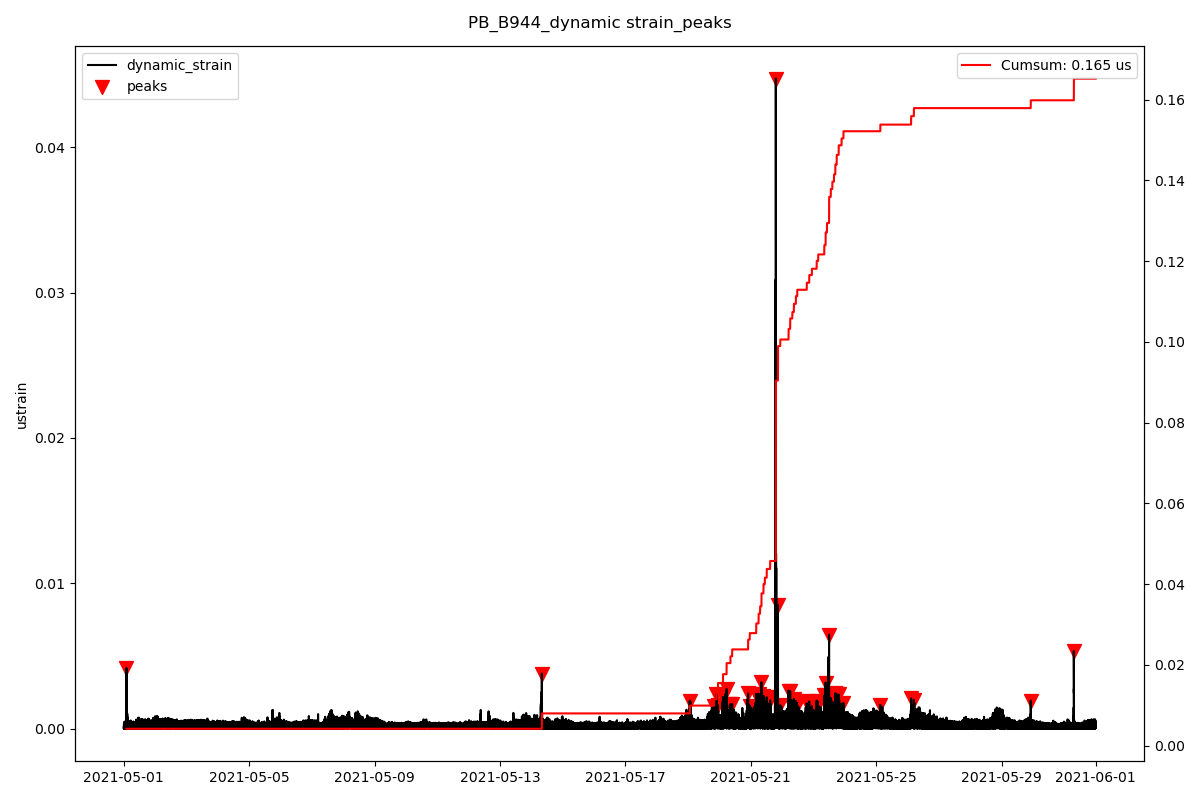

In [12]:
peaks_distance = 3600 / period #1 hr 
peaks_height = df_dynam.quantile(0.995).values[0]
print("cutoff height:", peaks_height)
plot_peaks(df_dynam, 
             title = f"{network}_{station}_dynamic strain_peaks",
             units='ustrain',
             plot_type = "line",
             peaks = True,
             peaks_distance = peaks_distance,
             peaks_height = peaks_height,
             save_as = None) 


### Load EQ catalog
- filter based on radius and magnitude to select events that might register at site
- adjust maxradius parameter for each radius to get more or less events

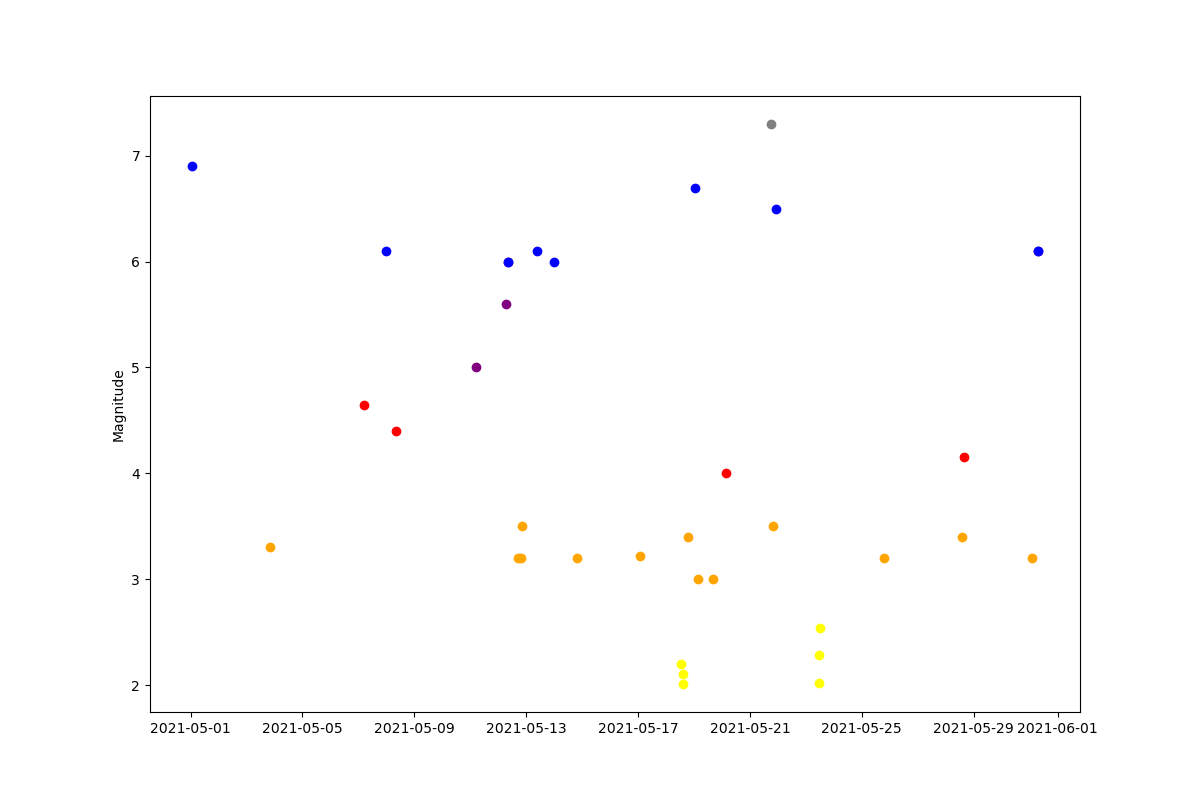

In [13]:
#start = "2021-05-01"
#end = "2021-06-01"

maxradiuskm2 = 100
minmag = 2
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm2}"
eqs2 = pd.read_csv(url, index_col='time', parse_dates=True)

maxradiuskm3 = 500
minmag = 3
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm3}"
eqs3 = pd.read_csv(url, index_col='time', parse_dates=True)

maxradiuskm4 = 1000
minmag = 4
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm4}"
eqs4 = pd.read_csv(url, index_col='time', parse_dates=True)

maxradiuskm5 = 4000
minmag = 5
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm5}"
eqs5 = pd.read_csv(url, index_col='time', parse_dates=True)


maxradiuskm6 = 10000
minmag = 6
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm6}"
#url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}"
eqs6 = pd.read_csv(url, index_col='time', parse_dates=True)

#maxradiuskm7 = 20000
minmag = 7
#url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}&latitude={meta.latitude}&longitude={meta.longitude}&maxradiuskm={maxradiuskm7}"
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={minmag}"
eqs7 = pd.read_csv(url, index_col='time', parse_dates=True)

eqs = [eqs2, eqs3, eqs4, eqs5, eqs6, eqs7]
colors = ['yellow','orange','red','purple', 'blue', 'grey']
labels = [f'M2<{maxradiuskm2}km', f'M3<{maxradiuskm3}km', f'M4<{maxradiuskm4}km', f'M5<{maxradiuskm5}km',f'M6<{maxradiuskm6}km', f'M7global']

def plot_eqs(eqs):
    fig, ax = plt.subplots(figsize=(12,8))
    
    for i, eq_df in enumerate(eqs):
        ax.scatter(eq_df.index, eq_df.mag, color=colors[i])
    ax.set_ylabel('Magnitude')
    plt.show()
plot_eqs(eqs)

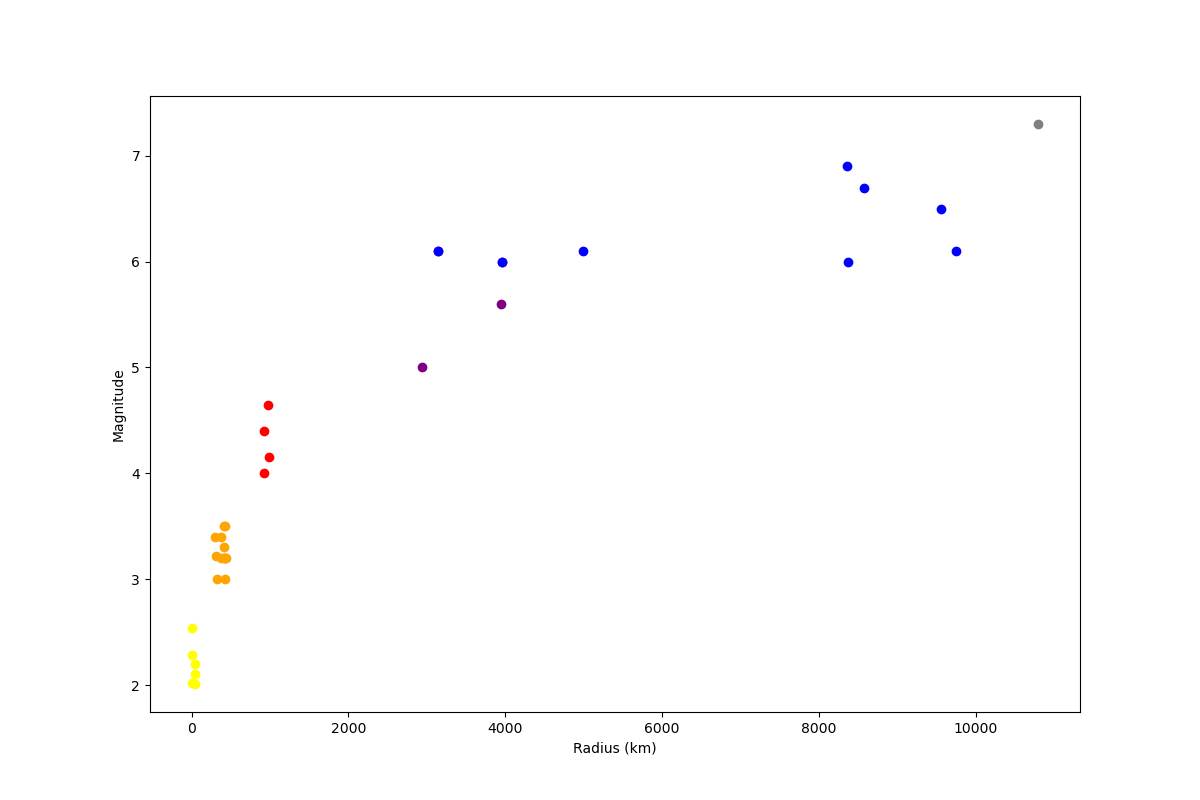

In [14]:
# plot eqs vs distance from station instead of time
for eq_df in eqs:
    for index in eq_df.index:
        radius = distance((eq_df.loc[index].latitude,eq_df.loc[index].longitude),(meta.latitude, meta.longitude)).km
        eq_df.at[index, 'radius'] = radius

def plot_eqs_distance_mag(eqs):
    fig, ax = plt.subplots(figsize=(12,8))
    for i, eq_df in enumerate(eqs):
        try:
            ax.scatter(eq_df.radius, eq_df.mag, color=colors[i])
        except:
            pass
    ax.set_ylabel('Magnitude')
    ax.set_xlabel('Radius (km)')
    plt.show()

plot_eqs_distance_mag(eqs)

### plot events as vertical lines to see how they match up with peaks identified from above methods
- matplotlib notebook plots allow zooming in and inspecting

In [15]:
def plot_peaks_vs_eqs(df: pd.DataFrame,
         title: str = None,
         units: str = None,
         plot_type: str = "scatter",
         peaks: bool = False,
         peaks_distance = None,
         peaks_height = None,
         eqs: list = None,
         save_as: str = None):
    
    colors = ['yellow','orange','red','purple', 'blue', 'grey']
    labels = [f'M2<{maxradiuskm2}km', f'M3<{maxradiuskm3}km', f'M4<{maxradiuskm4}km', f'M5<{maxradiuskm5}km',f'M6<{maxradiuskm6}km', f'M7global']
    
    #fig, axs = plt.subplots(len(df.columns), 1, figsize=(8, 5), squeeze=False)
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(12,8), squeeze=False)
    if title:
        fig.suptitle(title)
    for i, ch in enumerate(df.columns):
        if plot_type == 'line':
            axs[i][0].plot(df[ch], color='black', label=ch)
        elif plot_type == 'scatter':
            axs[i][0].scatter(df.index, df[ch], color='black', s=2, label=ch)
        else:
            print("Plot type must be either 'line' or 'scatter'")
        if units:
            axs[i][0].set_ylabel(units)
        if eqs:
            for j, eq_df in enumerate(eqs):
                for time in eq_df.index:
                    axs[i][0].axvline(time, color = colors[j], label=labels[j])
#                   #datetime.datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%fZ")
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[i][0].ticklabel_format(axis='y', useOffset=False, style='plain')
        axs[i][0].legend(by_label.values(), by_label.keys(), loc="upper left")
        
        if peaks:
            peak_idx = signal.find_peaks(df[ch], distance=peaks_distance, height=peaks_height)[0]
            peaks_df = df[ch].iloc[peak_idx]
            axs[i][0].scatter(peaks_df.index, peaks_df, color='red', s=100, marker="v", label='peaks')
            ax2 = axs[i][0].twinx()
            cumsum = pd.DataFrame(index=df.index, data=peaks_df.cumsum()).ffill()
            ax2.plot(cumsum,color='red', label=f'Cumsum: {round(peaks_df.cumsum().iloc[-1], 3)} us')
            #cumsum = pd.DataFrame(index=df.index, data=df.cumsum()).ffill()
            #ax2.plot(cumsum,color='red', label=f'Cumsum: {round(cumsum["dynamic_strain"].iloc[-1], 3)} us')
            ax2.legend(loc="upper right")
        
    fig.tight_layout()
    if save_as:
        logger.info(f"Saving plot to {save_as}")
        plt.savefig(save_as)



cutoff height: 0.0015649526168931712


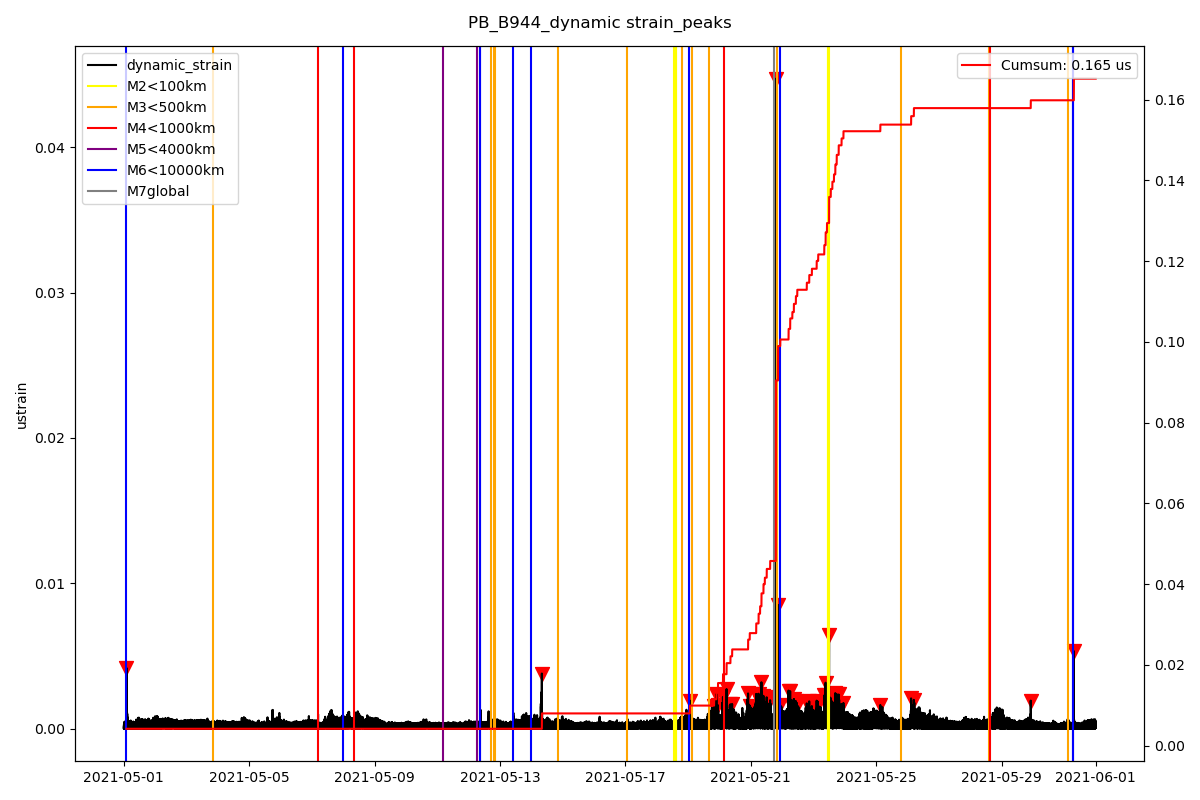

In [16]:
peaks_distance = 3600 / period #1 hr 
peaks_height = df_dynam.quantile(0.995).values[0]
print("cutoff height:", peaks_height)
plot_peaks_vs_eqs(df_dynam, 
             title = f"{network}_{station}_dynamic strain_peaks",
             units='ustrain',
             plot_type = "line",
             peaks = True,
             peaks_distance = peaks_distance,
             peaks_height = peaks_height,
             eqs=eqs,
             save_as = None) 



# Areal Strain
Same methods but using areal strain instead of combining 4 individual gauge strains.

### Convert to areal strain 

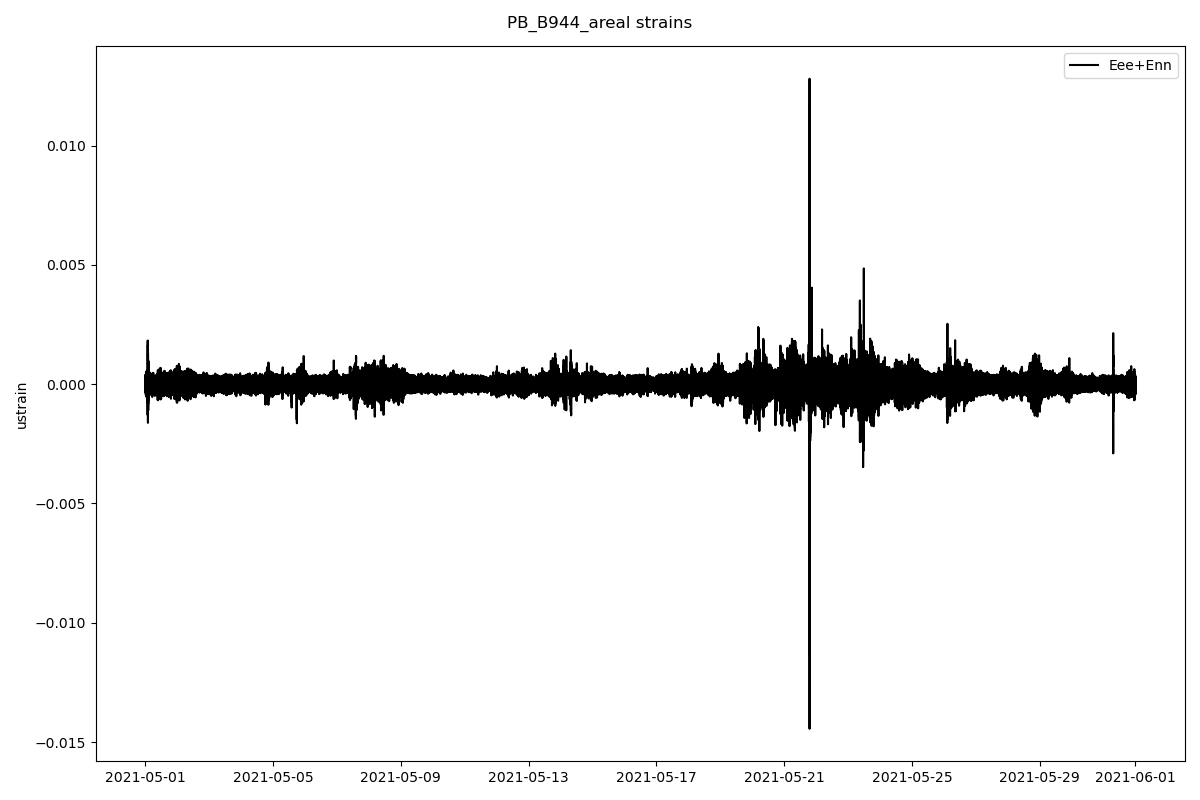

In [17]:
regional_df = np.matmul(meta.strain_matrices['lab_strain_matrix'],
                               df2.transpose()).transpose()
regional_df = regional_df.rename(columns={0: "Eee+Enn", 1: "Eee-Enn", 2: "2Ene"})

plot(regional_df[['Eee+Enn']], 
     title = f"{network}_{station}_areal strains",
     units='ustrain',
     remove_9s = True,
     zero = False,
     detrend = None,
     ymin = None,
     ymax = None,
     plot_type = "line",
     save_as = None) 

### Take the absolute value of the areal strain signal, find peaks
- want signal to be positive only, so take the square root of the square (similar to above)
- have chosen here 1 hr peak width, and height cutoff at 99.5% quantile.  note above we used 99.9% quantile.

cutoff height: 0.0011086911011474652


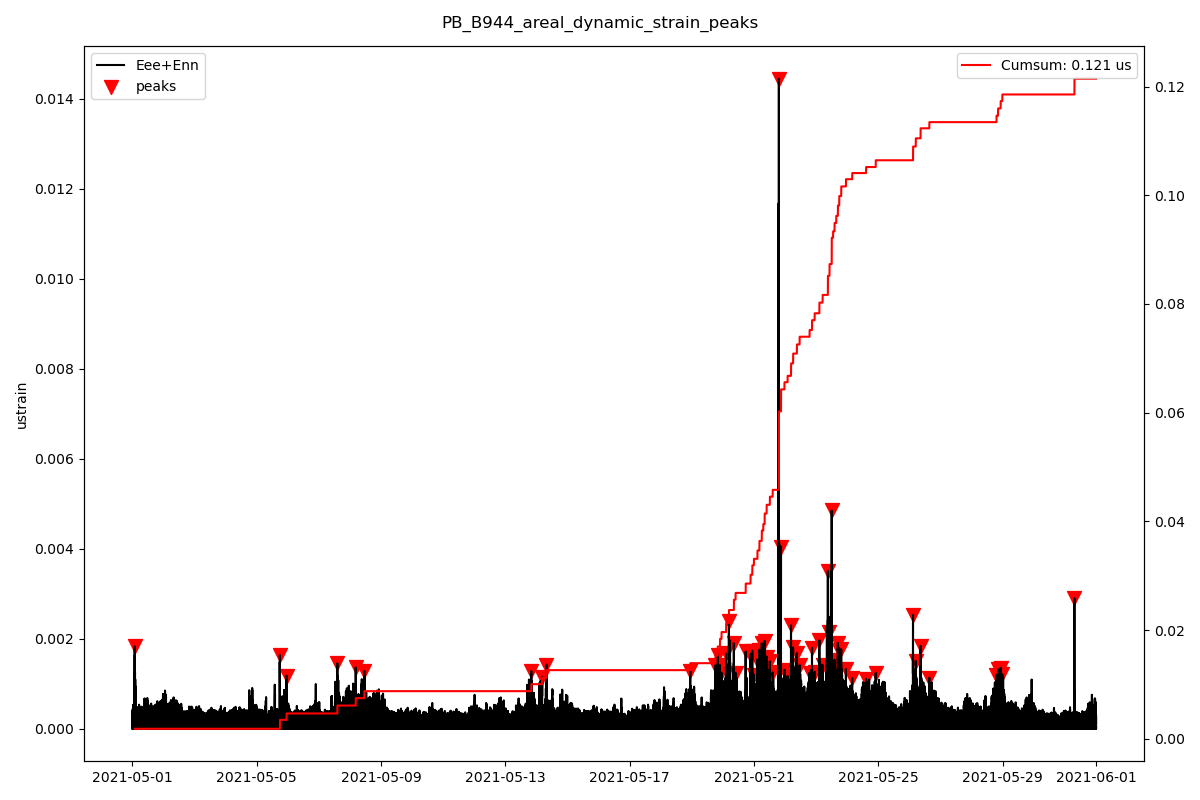

In [18]:
areal_abs = np.sqrt((np.square(regional_df['Eee+Enn']))).to_frame()
peaks_distance = 3600 / period #1 hr 
peaks_height = areal_abs.quantile(0.995).values[0]
print("cutoff height:", peaks_height)
plot_peaks(areal_abs, 
             title = f"{network}_{station}_areal_dynamic_strain_peaks",
             units='ustrain',
             plot_type = "line",
             peaks = True,
             peaks_distance = peaks_distance,
             peaks_height = peaks_height,
             save_as = None) 



### Same plot but with earthquakes added

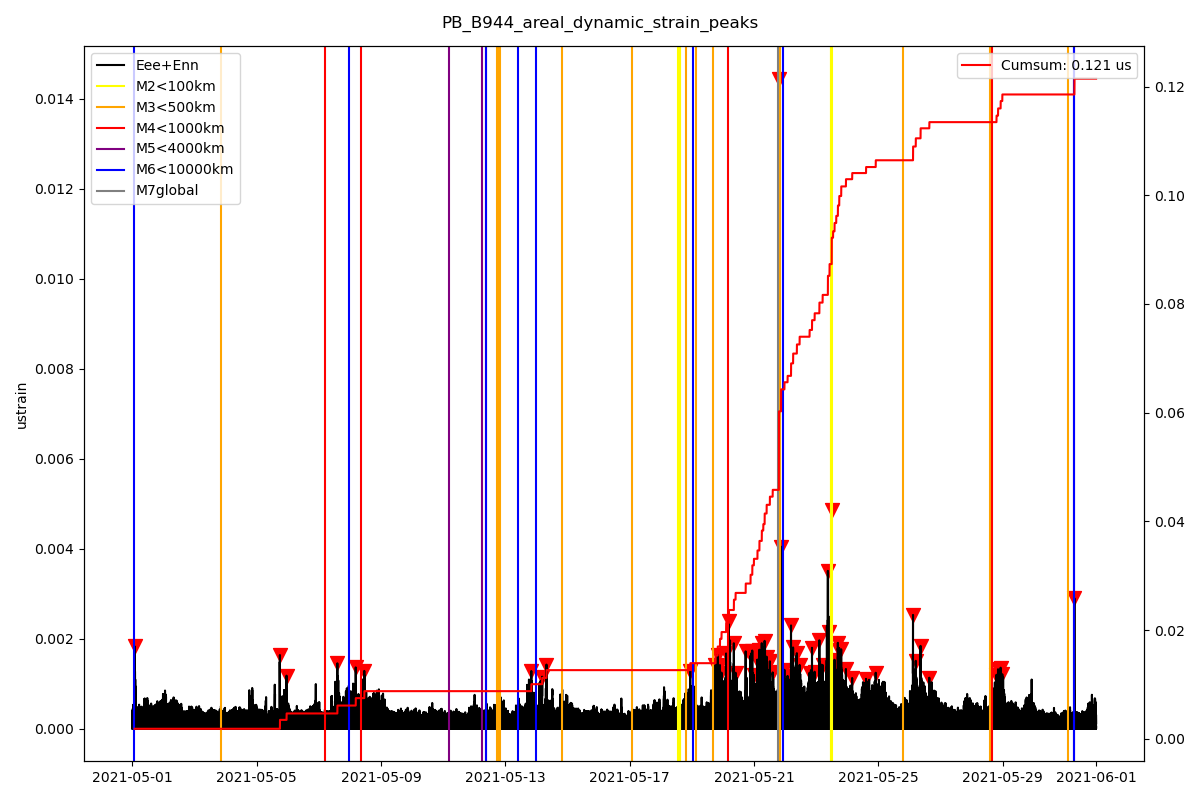

In [19]:
plot_peaks_vs_eqs(areal_abs, 
     title = f"{network}_{station}_areal_dynamic_strain_peaks",
     units='ustrain',
     plot_type = "line",
     peaks = True,
     peaks_distance = peaks_distance,
     peaks_height = peaks_height,
     eqs=eqs,
     save_as = None) 